In [1]:
import os
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import sklearn
import h5py
from tensorflow.keras import backend as K
from scipy.io import loadmat

In [2]:
data_dir = "/DATA/phan92/tbi_diagnosis/data/raw/cardiac_displacement_3_updated_Oct13"

In [3]:
IPH_patients = ['DoD008', 'DoD009', 'DoD010', 'DoD012', 'DoD022', 'DoD047', 'DoD053', 
                'DoD062', 'DoD066', 'DoD067', 'DoD069', 'DoD074', 'DoD075', 'DoD078', 
                'DoD085', 'DoD089', 'DoD093', 'DoD101', 'DoD105', 'DoD107', 'DoD110', 
                'DoD112', 'DoD113', 'DoD120', 'DoD121', 'DoD126', 'DoD129', 'DoD130', 
                'DoD133']

old_bad_patients = [1, 14, 22, 23, 27, 28, 32, 34, 35, 36, 37, 38, 39, 44, 49, 69, 71, 
                78, 82, 90, 98, 101, 121, 124, 128, 133, 928]

bad_patients = ['DoD027', 'DoD028', 'DoD035', 'DoD036', 'DoD038', 'DoD049', 'DoD069', 'DoD090']

In [ ]:
# find out all different size of the dataset
data_sizes = []
for patient in os.listdir(data_dir):
    for scan in os.listdir(os.path.join(data_dir, patient)):
        data = loadmat(os.path.join(data_dir, patient, scan))
        size_of_displacement = data['displacement'].shape
        print(scan, size_of_displacement)
        if size_of_displacement not in data_sizes:
            data_sizes.append(size_of_displacement)

In [ ]:
len(data_sizes)

In [ ]:
data_sizes

In [16]:
# Extract axis information to produce cone-shape images
def extract_axis(datapath, axisPath):
    data = loadmat(datapath)

    xaxis = np.array(list(data['xAxis']))
    yaxis = np.array(list(data['zAxis']))

    xaxis = cv2.resize(xaxis, (80, 256), interpolation=cv2.INTER_AREA)
    yaxis = cv2.resize(yaxis, (80, 256), interpolation=cv2.INTER_AREA)

    xaxis += 100
    yaxis -= 4

    print("saved axis info in : {}".format(axisPath))
    np.save(os.path.join(axisPath, "xAxis.npy"), xaxis)
    np.save(os.path.join(axisPath, "yAxis.npy"), yaxis)
    
    return xaxis, yaxis

In [17]:
# extract generic axis information
axisPath = "/DATA/phan92/notebooks"
rand_input_file = "/DATA/phan92/test_resource/raw_data/DoD110/DoD110_Ter002_LO1_Displacement_Normalized_3.mat"
xAxis, yAxis = extract_axis(rand_input_file, axisPath)

saved axis info in : /DATA/phan92/notebooks


In [ ]:
# extract specific axis information of a patient
axisPath = "/DATA/phan92/notebooks"
input_file = "/DATA/phan92/tbi_diagnosis/data/raw/cardiac_displacement_3_updated_Oct13/DoD042/DoD042_Ter015_LO5_Displacement_Normalized_3.mat"
xAxis, yAxis = extract_axis(input_file, axisPath)

In [ ]:
def normalize_displacement(displace_data):
    """
    Normalize displacement data

    Args:
        displace_data (numpy array): 10 points of displacement data in a cardiac cycle
    Return:
        displace_data (numpy array): normalized 10 points of displacement
    """
    displace_data = displace_data - displace_data.mean(axis=0).mean(axis = 0)
    safe_max = np.abs(displace_data).max(axis=0).max(axis=0)
    safe_max[safe_max == 0] = 1
    displace_data = displace_data / safe_max
    displace_data = cv2.resize(displace_data, (80, 256))

    return displace_data

In [ ]:
def extract_displace_data(rawData):
    """
    Extract the displacement data from a patient file.
    Ignore the last cardiac cycle.
    Take 10 points from the start of a cardiac cycel

    Args:
        rawData (raw from .mat): raw data loaded from .mat file

    Return:
        displace_data (numpy array): displacement data
    """
    displacement = np.array(list(rawData['displacement']))
    hrTimes = np.array(list(rawData['hrTimes']))
    hrShape = hrTimes.shape
    disShape = displacement.shape
    displace_data = np.zeros([disShape[0], disShape[1], 10, hrShape[1] - 1])
    for h in range(0, hrShape[1] - 1):
        start = int(math.ceil(30 * hrTimes[0, h]))
        displace_data[:, :, :, h] = displacement[:, :, start: start + 10]
    
    return np.array(displace_data.astype('float64'))

In [ ]:
def process_patients(path, objective, patient_nums=None):
    """
    Process data of all patients

    Args:
        path (string): path to folder storing patient data
        objective (integer): 0-brain mask, 1-blood mask
        patient_nums (list(string)): list of patient numbers to process;
                                process all if None is given;
                                format: DoDxxx
    Return:
        1. numpy array of displacement data, label, and bMode
        2. list of patient files
    """
    patients_data = []
    file_list = []
    
    # process all if no patient number is given
    if patient_nums is None:
        for patient in os.listdir(path):
            dataPath = os.path.join(path, patient)
            data, fileNames = process_data(path=dataPath, objective=objective)
            patients_data.extend(data)
            file_list.extend(fileNames)
    # process only the given patients
    else:
        for patient_num in patient_nums:
            if os.path.isdir(os.path.join(path, patient_num)):
                dataPath = os.path.join(path, patient_num)
                data, fileNames = process_data(path=dataPath, objective=objective)
                patients_data.extend(data)
                file_list.extend(fileNames)
            else:
                print('Patient' + patient_num + 'does not exist')
    
    return np.array(patients_data), np.array(file_list)

In [ ]:
def process_data(path, objective):
    """
    Process the raw data for a patient
    """
    # list of input images
    data = []
    # list of file names
    fileNames = []
    # process all file in the directory
    for file in os.listdir(path):
        if ".mat" in file:
            filePath = os.path.join(path, file)
            fileName = file[0:17]
            rawData = loadmat(filePath)
            # get the labels
            normalMask = np.array(list(rawData['normalMask'])) 
            bloodMask = np.array(list(rawData['bloodMaskThick']))
            brainMask = np.array(list(rawData['brainMask']))
            bMode = np.array(list(rawData['bModeNorm']))

            if len(bloodMask) == 0:
                break
            
            # extract the displacement data
            displace_data = extract_displace_data(rawData)
            
            # resize the masks
            normalMask = cv2.resize(normalMask, (80, 256))
            bloodMask = cv2.resize(bloodMask, (80, 256))
            brainMask = cv2.resize(brainMask, (80, 256))
            bMode = np.log10(bMode)
            bMode = bMode.astype('float64')
            bMode = np.mean(bMode, axis=2)

            # create label
            if objective == 0:
                label = np.where(brainMask == 0, 0, 1)
            else:
                label = bloodMask + 1
                label = label.astype('float32')
                label = np.where(brainMask == 0, 0, label)

            label = label.reshape([256, 80, 1])
            n_cycles = displace_data.shape[-1]

            # normalize
            for k in range(0, n_cycles):
                displace_data0 = displace_data[:, :, :, k]
                displace_data0 = normalize_displacement(displace_data0)
               
                bMode0 = bMode[:, :, k]
                bMode0 = cv2.resize(bMode0, (80, 256))
                bMode0 = bMode0.reshape([256, 80, 1])

                if objective == 1:
                    # delete non-brain from input
                    for i in range(0, displace_data0.shape[-1]):
                        displace_data0[:, :, i] = np.where(brainMask == 0, 0.0, displace_data0[:, :, i])

                # concatenate into one structure
                sample = np.concatenate((label, displace_data0, bMode0), axis=2)
                
                data.append(sample)
                fileNames.append(fileName + '_cycle' + str(k + 1))
    return data, fileNames

In [ ]:
def split_data(data, nameList, savePath, test_size=0.2, random_state=42):
    """
    Split the data into train and test set and save to file
    
    Args:
        data (numpy array): the data to operate on
        pathList (numpy array): the list of file name correspond to the data
        test_size (float): the propotion of the test set
        random_state (int): maintain the consistency between the data and file names
    
    Return: None
    """
    train_data, test_data, train_list, test_list = train_test_split(
                                                        data, 
                                                        nameList,
                                                        test_size=test_size,
                                                        random_state=random_state
                                                    )
    np.save(os.path.join(savePath, "TrainingData.npy"), train_data)
    np.save(os.path.join(savePath, "TestingData.npy"), test_data)
    np.save(os.path.join(savePath, "TrainingPaths.npy"), train_list)
    np.save(os.path.join(savePath, "TestingPaths.npy"), test_list)

In [ ]:
def disp_input(x, xAxis, yAxis, displacement_pos):
    """
    Display an input
    
    @param: x: numpy array contain the data, bmode, and mask
    @param: displacement_pos: position of the extracted displacement (1 - 10)
    @param: xAxis: the rescale axis used to display cone shape
    @param: yAxis: the rescale axis used to display cone shape
    """
    image = x
    # get the label
    label = image[:, :, 0]
    label.reshape([256, 80])
    # get bmode
    bmode = image[:, :, 11]
    bmode.reshape([256, 80])
    _, bin_edges = np.histogram(image, bins=25)
    # get displacement
    displacement = image[:, :, displacement_pos]
    displacement.reshape([256, 80])
    # display
    fig, ax = plt.subplots(1, 3, figsize=(24, 6))
    ax[0].pcolormesh(xAxis, -yAxis, label, shading='auto', cmap='magma', vmin=0, vmax=2)
    ax[1].pcolormesh(xAxis, -yAxis, bmode, shading='auto', cmap='binary', vmin=bin_edges[2], vmax=bin_edges[-2])
    ax[2].pcolormesh(xAxis, -yAxis, displacement, shading='auto')
    
    plt.show()

In [ ]:
# get data from file
data, fileList = process_patients(data_dir, objective=1, patient_nums=['DoD009'])

In [ ]:
data.shape

In [ ]:
fileList

In [ ]:
disp_input(data[1,:,:,:], xAxis, yAxis, displacement_pos=1)

In [ ]:
def display_input(label, bMode, displacement, xAxis, yAxis):
    """
    Display an input
    
    Args:
        label (numpy.arr): the label
        bMode (numpy.arr): bMode
        displacement (numpy.arr): displacement
        xAxis (numpy.arr): numpy array contain x axis for display the cone
        yAxis (numpy.arr): numpy array contain y axis for display the cone
    """
    label.reshape([256, 80])
    bMode.reshape([256, 80])
    _, bin_edges = np.histogram(bMode, bins=25)
    displacement.reshape([256, 80])
    # display
    fig, ax = plt.subplots(1, 3, figsize=(24, 6))
    ax[0].pcolormesh(xAxis, -yAxis, label, shading='auto', cmap='magma', vmin=0, vmax=2)
    ax[1].pcolormesh(xAxis, -yAxis, bMode, shading='auto', cmap='binary', vmin=bin_edges[2], vmax=bin_edges[-2])
    ax[2].pcolormesh(xAxis, -yAxis, displacement, shading='auto')
    
    plt.show()

In [ ]:
def standardize(displacement, x_dim, y_dim):
    """
    Normalize displacement data

    Args:
        displacement (numpy array): one displacement frame
        x_dim (int): horizontal dim of the final image
        y_dim (int): vertical dim of the final image
    Return:
        displace_data (numpy array): normalized displacement
    """
    
    displacement = displacement - displacement.mean(axis=0)
    safe_max = np.abs(displacement).max(axis=0)
    safe_max[safe_max == 0] = 1
    displacement = displacement / safe_max
    displacement = cv2.resize(displacement, (y_dim, x_dim))

    return displacement

In [ ]:
def standardize(displacement, x_dim, y_dim):
    """
    Standardize displacement data
    Output values have a mean of 0 and std = 1

    Args:
        displacement (numpy array): one displacement frame
        x_dim (int): horizontal dim of the final image
        y_dim (int): vertical dim of the final image
    Return:
        displace_data (numpy array): normalized displacement
    """
    
    centered = displacement - displacement.mean()
    
    # divide by the standard deviation
    if np.std(centered) != 0:
        centered_scaled = centered / np.std(centered)
        
    displacement = cv2.resize(centered_scaled, (y_dim, x_dim))

    return displacement

In [ ]:
def extract_single_frame_from_raw_displacement(rawData, cardiac_cycle=1, displacement_pos=0):
    """
    Extract the displacement data from a patient file
    Choose one cardiac cycle and a displacement in this cardiac cycle
    
    Args:
        rawData (raw from .mat): raw data loaded from .mat file
        cardiac_cycle (int): number of the th cycle to extract data from
        displacement_pos (int): the location of the displacement after the start
                            of the cardiac cycle 
    Returns:
        displace_data (numpy array): displacement data
    """
    displacement = np.array(list(rawData['displacement']))
    hrTimes = np.array(list(rawData['hrTimes']))
    disShape = displacement.shape
    # extract data from the cardiac_cycle th cycle
    start = int(math.ceil(30 * hrTimes[0, cardiac_cycle]))
    displace_data = np.zeros([disShape[0], disShape[1], 1])
    # take the th displacement after the start of a cardiac cycle
    displace_data[:,:,0] = displacement[:, :, start + displacement_pos]
    
    return np.array(displace_data.astype('float64'))

In [ ]:
def make_label(rawData, x_dim, y_dim, objective):
    """
    Make the label according to model's objective
    Objective = 0: find brain tissue
    Objective = 1: find bleed
    
    Args:
        rarData: data read from loadmat()
        objective (int): find brain or fine bleed
        x_dim (int): horizontal dim of the final image
        y_dim (int): vertical dim of the final image
    
    Return:
        label (numpy.arr): the label (x_dim, y_dim)
    """
    # get the labels
    bloodMask = np.array(list(rawData['bloodMaskThick']))
    brainMask = np.array(list(rawData['brainMask']))
    
    # resize the masks
    bloodMask = cv2.resize(bloodMask, (y_dim, x_dim))
    brainMask = cv2.resize(brainMask, (y_dim, x_dim))
    
    # create label
    if objective == 0:
        label = np.where(brainMask == 0, 0, 1)
    else:
        label = bloodMask + 1
        label = label.astype('float32')
        label = np.where(brainMask == 0, 0, label)

    return label

In [ ]:
def get_bMode(rawData, x_dim, y_dim):
    """
    Get the bMode image from raw data
    
    Args:
        rarData: data read from loadmat()
        x_dim (int): horizontal dim of the final image
        y_dim (int): vertical dim of the final image
        
    Returns:
        bMode (numpy.arr): bMode image (x_dim, y_dim)
    """
    # get the bmode from raw data
    bMode = np.array(list(rawData['bModeNorm']))
    
    # resize
    bMode = np.log10(bMode)
    bMode = bMode.astype('float64')
    
    # some bModeNorm data have dimensions (x_dim, y_dim)
    # those do not need to be processed in the if statement
    if len(bMode.shape) > 2:
        bMode = np.mean(bMode, axis=2)
        bMode = bMode[:, :, 0]
    bMode = cv2.resize(bMode, (y_dim, x_dim))
    
    return bMode

In [ ]:
def process_data_2(path, x_dim, y_dim, objective):
    """
    Process the raw data for a patient
    
    Args:
        path (str): path to the data file
        objective (int): the objective of processing (0 to find skull, 1 to find bleed)
        x_dim (int): horizontal dim of the final image
        y_dim (int): vertical dim of the final image
        
    Returns:
        displacement_list: displacement frames from a mat file (N, x_dim, y_dim, 1)
        label_list: labels (N, x_dim, y_dim, 1)
        bMode_list: corresponding bMode images (N, x_dim, y_dim, 1)
        fileNames: names of files where data come from (N,)
    """
    # list of displacement
    displacement_list = []
    # list of bMode
    bMode_list = []
    #list of labels
    label_list = []
    # list of file names
    fileNames = []
    # process all file in the directory
    for file in os.listdir(path):
        if ".mat" in file:
            filePath = os.path.join(path, file)
            rawData = loadmat(filePath)
            
            # extract the displacement data
            displace_data = extract_single_frame_from_raw_displacement(rawData)
            # standardize
            displace_data = standardize(displace_data, x_dim, y_dim)
            displace_data = displace_data.reshape([x_dim, y_dim, 1])
            """
            if objective == 1:
                # delete non-brain from input
                displace_data[:,:,0] = np.where(brainMask == 0, 0.0, displace_data[:,:,0]) """
            
            # get bMode images
            bMode = get_bMode(rawData, x_dim, y_dim)
            
            # make label
            label = make_label(rawData, x_dim, y_dim, objective)

            displacement_list.append(displace_data)
            label_list.append(label)
            bMode_list.append(bMode)
            fileNames.append(file)
    return displacement_list, label_list, bMode_list, fileNames

In [ ]:
def process_patients_2(path, objective=1, x_dim=256, y_dim=80, patient_nums=None):
    """
    Process data of all patients

    Args:
        path (string): path to folder storing patient data
        objective (integer): 0-brain mask, 1-blood mask
        patient_nums (list(string)): list of patient numbers to process;
                                process all if None is given;
                                format: DoDxxx
        x_dim (int): horizontal dim of the final image
        y_dim (int): vertical dim of the final image
    Return:
        1. numpy array of displacement data, label, and bMode
        2. list of patient files
    """
    displacement_list = []
    label_list = []
    bMode_list = []
    file_list = []
    
    # process all if no patient number is given
    if patient_nums is None:
        patient_nums = [patient for patient in os.listdir(path) if patient not in bad_patients]
    
    for patient_num in patient_nums:
        if os.path.isdir(os.path.join(path, patient_num)):
            print("Process data for patient", patient_num)
            dataPath = os.path.join(path, patient_num)
            displacement, label, bMode, fileNames = process_data_2(path=dataPath, x_dim=x_dim, y_dim=y_dim, objective=objective)
            displacement_list.extend(displacement)
            label_list.extend(label)
            bMode_list.extend(bMode)
            file_list.extend(fileNames)
        else:
            print('Patient' + patient_num + 'does not exist')
    
    print("Processed", len(patient_nums), "patients")
    
    return np.array(displacement_list), np.array(label_list), np.array(bMode_list), np.array(file_list)

In [ ]:
# get data from file
displacement, label, bMode, fileList = process_patients_2(data_dir, 
                                                          objective=1, 
                                                          x_dim=256, 
                                                          y_dim=80, 
                                                          patient_nums=['DoD009'])

In [ ]:
displacement.shape

In [ ]:
label.shape

In [ ]:
bMode.shape

In [ ]:
plt.pcolormesh(xAxis, -yAxis, np.squeeze(displacement[0,:,:,:], axis=-1), shading='flat')

In [ ]:
plt.pcolormesh(xAxis, -yAxis, np.squeeze(displacement[0,:,:,:], axis=-1), shading='flat')

In [ ]:
display_input(label[0,:,:], bMode[0,:,:], displacement[0,:,:,0], xAxis, yAxis)

In [ ]:
def one_hot(label, num_classes=3):
    """
    Create one hot label from the provided label
    
    Args:
        label: label of shape (N, x_dim, y_dim)
        num_classes (int): number of classes to resolve
        
    Returns:
        label: onehot label (N, x_dim, y_dim, n_channels)
    """
    if num_classes == 2:
        # create label to find brain tissue
        # if the probability of brain is >= 0.5
        # set the label to 1, 0 otherwise
        label = np.where(label >= 0.5, 1, 0)
    else:
        # create label to find bleed
        # if the probability of bleed is >= 0.3
        # set the label to 1
        label = np.where(label >= 1.3, 1, 0)

    label = np.expand_dims(label, axis=3)
    #label = np.moveaxis(label, 3, 1)
    
    return label

In [ ]:
def make_hdf5(save_path, data_path):
    """
    Make hdf5 data file
    
    @param: save_path: path to saved file
    @param: data_path: path to raw data
    """
    
    # process data
    displacement, label, bMode, fileNames = process_patients_2(data_path, objective=1, patient_nums=None)
    
    # change the dimensions of displacement
    # from (N, x_dim, y_dim, n_channel)
    # to (N, n_channel, x_dim, y_dim)
    #displacement = np.moveaxis(displacement, 3, 1)
    
    # remove the n_channel from label and bMode
    # from (N, x_dim, y_dim, n_channel = 1)
    # to (N, x_dim, y_dim)
    #label = np.squeeze(label, axis=3)
    #bMode = np.squeeze(bMode, axis=3)
    
    # convert label to one hot
    # shape (N, n_class, x_dim, y_dim)
    label = one_hot(label)
    
    # create a hdf5 file
    f = h5py.File(os.path.join(save_path,'displacement_data.hdf5'), 'w')
    
    training_group = f.create_group("training")
    testing_group = f.create_group('testing')
    
    # shuffle the dataset
    displacement, label, bMode, fileNames = sklearn.utils.shuffle(displacement, 
                                                                  label, 
                                                                  bMode, 
                                                                  fileNames, 
                                                                  random_state=0)
    
    num_examples = displacement.shape[0]
    # add data to the defined data buckets
    _add_dataset(training_group, 
                 displacement[0: int(0.8*num_examples)],
                 label[0: int(0.8*num_examples)],
                 bMode[0: int(0.8*num_examples)],
                 fileNames[0: int(0.8*num_examples)])
    _add_dataset(testing_group, 
                 displacement[int(0.8*num_examples):], 
                 label[int(0.8*num_examples):],
                 bMode[int(0.8*num_examples):],
                 fileNames[int(0.8*num_examples):])
    
    f.close()

In [ ]:
def _add_dataset(group: h5py.Group, displacement, label, bMode, fileNames):
    """
    Add a dataset to h5py group
    The saved data have shapes:
        x (N, nchannel, 256, 80)
        y (N, n_class, 256, 80)
        bMode (N, 256, 80)
        names (N, 1)
    
    @param: group: h5py group
    @param: displacement: displacement data (N, n_channel, x_dim, y_dim)
    @param: label: label (N, n_class, x_dim, y_dim)
    @param: bMode: bMode ultrasound (N, x_dim, y_dim)
    @param: fileNames: file names of the displacement data (N,)
    """
    # convert the label to a ASCII format for h5py
    asciiList = [name.encode("ascii", "ignore") for name in fileNames]
    
    x = group.create_dataset('x', data=displacement)
    y = group.create_dataset('y', data=label)
    bMode = group.create_dataset('bMode', data=bMode)
    filename = group.create_dataset('filename', data=asciiList)

In [ ]:
make_hdf5('/DATA/phan92/tbi_diagnosis/data/processed', data_dir)

In [4]:
dataset = h5py.File('/DATA/phan92/tbi_diagnosis/data/processed/displacement_data.hdf5', 'r')

In [5]:
test = dataset['testing']

In [6]:
x = test['x']

In [7]:
x

<HDF5 dataset "x": shape (359, 256, 80, 1), type "<f8">

In [8]:
train = dataset['training']

In [9]:
train

<HDF5 group "/training" (4 members)>

In [10]:
y = train['y']

In [19]:
y

<HDF5 dataset "y": shape (1433, 256, 80, 1), type "<i8">

In [14]:
np.unique(y)

array([0, 1])

/tmp/ipykernel_10192/2713247775.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(xAxis, -yAxis, np.squeeze(y[6], axis=-1), shading='auto')


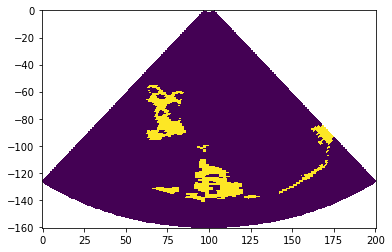

In [25]:
plt.pcolormesh(xAxis, -yAxis, np.squeeze(y[6], axis=-1), shading='auto')

In [ ]:
for name in names:
    print(name)

In [ ]:
plt.pcolormesh(xAxis, -yAxis, np.squeeze(y[0], axis=0), shading='auto')

In [ ]:
dataset.close()

# Descriptive statistics of the data

In [ ]:
rawDataPath = '/DATA/phan92/raw_data/cardiac_displacement_3_updated_Oct13'

In [ ]:
data = []
fileNames = []

In [ ]:
# collect the data
for patient in os.listdir(rawDataPath):
    print(patient)
    patient_num = int(patient[3:])
    print(patient_num)
    if patient_num not in bad_patients:
        patientPath = os.path.join(rawDataPath, patient)
        for scan in os.listdir(patientPath):
            scanPath = os.path.join(patientPath, scan)
            fileNames.append(scanPath)
            rawData = loadmat(scanPath)
            displacement = np.array(list(rawData['displacement']))
            hrTimes = np.array(list(rawData['hrTimes']))
            hrShape = hrTimes.shape
            disShape = displacement.shape
            for h in range(0, hrShape[1] - 1):
                start = int(math.ceil(30 * hrTimes[0, h]))
                # get 10 points after start of a cardiac cycle
                for i in range(0, 11):
                    data.append(displacement[:, :, start + i])

In [ ]:
data = np.array(data)

In [ ]:
data.shape

In [ ]:
# collect the data
for patient in os.listdir(rawDataPath):
    print(patient)
    patientPath = os.path.join(rawDataPath, patient)
    for scan in os.listdir(patientPath):
        scanPath = os.path.join(patientPath, scan)
        fileNames.append(scanPath)
        rawData = loadmat(scanPath)
        data.append(np.array(rawData['displacement']))

In [ ]:
average = []
maximum = []
minimum = []

In [ ]:
for sample in data:
    average.append(np.mean(sample))
    maximum.append(np.max(sample))
    minimum.append(np.min(sample))

In [ ]:
# max of maximum
np.max(maximum)

In [ ]:
# min of maximum
np.min(maximum)

In [ ]:
# average of maximum
np.mean(maximum)

In [ ]:
# max of minimum
np.max(minimum)

In [ ]:
# min of minimum
np.min(minimum)

In [ ]:
# average of minimum
np.mean(minimum)

In [ ]:
max_by_99percentile = np.percentile(data, 99.0)

In [ ]:
# resize the data
resized_data = []
for sample in data:
    resized_sample = cv2.resize(sample, (80, 256))
    resized_data.append(resized_sample)

In [ ]:
resized_data = np.array(resized_data)

In [ ]:
resized_data.shape

In [ ]:
resized_sample = resized_data[0]

In [ ]:
plt.pcolormesh(xAxis, -yAxis, resized_sample, shading='auto', cmap='nipy_spectral')
plt.show()

In [ ]:
resized_average = []
resized_maximum = []
resized_minimum = []

In [ ]:
for sample in resized_data:
    resized_average.append(np.mean(sample))
    resized_maximum.append(np.max(sample))
    resized_minimum.append(np.min(sample))

In [ ]:
# max of maximum
np.max(resized_maximum)

In [ ]:
# min of maximum
np.min(resized_maximum)

In [ ]:
# average of maximum
np.mean(resized_maximum)

In [ ]:
# max of minimum
np.max(resized_minimum)

In [ ]:
# min of minimum
np.min(resized_minimum)

In [ ]:
# average of minimum
np.mean(resized_minimum)

In [ ]:
max_by_99point9percentile = np.percentile(np.array(resized_data), 99.9)

In [ ]:
max_by_99point9percentile

In [ ]:
plt.hist(resized_data.flatten())
plt.yscale('log')
plt.show()

# Old code

In [ ]:
def process_data_2(path, objective):
    """
    Process the raw data for a patient
    
    @param: path: path to the data file
    @param: objective: the objective of processing (0 to find skull, 1 to find bleed)
    
    @return: data: processed data
    @return: fileNames: associated file names
    """
    # list of input images
    data = []
    # list of file names
    fileNames = []
    # process all file in the directory
    for file in os.listdir(path):
        if ".mat" in file:
            filePath = os.path.join(path, file)
            fileName = file[0:17]
            rawData = loadmat(filePath)
            # get the labels
            normalMask = np.array(list(rawData['normalMask'])) 
            bloodMask = np.array(list(rawData['bloodMaskThick']))
            brainMask = np.array(list(rawData['brainMask']))
            bMode = np.array(list(rawData['bModeNorm']))

            if len(bloodMask) == 0:
                break
            
            # extract the displacement data
            displace_data = extract_displace_data_2(rawData)
            
            # resize the masks
            normalMask = cv2.resize(normalMask, (80, 256))
            bloodMask = cv2.resize(bloodMask, (80, 256))
            brainMask = cv2.resize(brainMask, (80, 256))
            bMode = np.log10(bMode)
            bMode = bMode.astype('float64')
            bMode = np.mean(bMode, axis=2)

            # create label
            if objective == 0:
                label = np.where(brainMask == 0, 0, 1)
            else:
                label = bloodMask + 1
                label = label.astype('float32')
                label = np.where(brainMask == 0, 0, label)

            label = label.reshape([256, 80, 1])
            n_cycles = displace_data.shape[-1]

            # normalize
            displace_data = normalize_displacement(displace_data)
            #displace_data = displace_data * 255
            #displace_data = cv2.resize(displace_data, (80, 256))
            displace_data = displace_data.reshape([256, 80, 1])
            
            # take the 1th bModeNorm
            bMode = bMode[:, :, 0]
            bMode = cv2.resize(bMode, (80, 256))
            bMode = bMode.reshape([256, 80, 1])

            if objective == 1:
                # delete non-brain from input
                displace_data[:,:,0] = np.where(brainMask == 0, 0.0, displace_data[:,:,0])

            # concatenate into one structure
            sample = np.concatenate((label, displace_data, bMode), axis=2)

            data.append(sample)
            fileNames.append(fileName)
    return data, fileNames

In [ ]:
def process_patients_2(path, objective, patient_nums=None):
    """
    Process data of all patients

    Args:
        path (string): path to folder storing patient data
        objective (integer): 0-brain mask, 1-blood mask
        patient_nums (list(string)): list of patient numbers to process;
                                process all if None is given;
                                format: DoDxxx
    Return:
        1. numpy array of displacement data, label, and bMode
        2. list of patient files
    """
    patients_data = []
    file_list = []
    
    # process all if no patient number is given
    if patient_nums is None:
        for patient in os.listdir(path):
            dataPath = os.path.join(path, patient)
            data, fileNames = process_data_2(path=dataPath, objective=objective)
            patients_data.extend(data)
            file_list.extend(fileNames)
    # process only the given patients
    else:
        for patient_num in patient_nums:
            if os.path.isdir(os.path.join(path, patient_num)):
                dataPath = os.path.join(path, patient_num)
                data, fileNames = process_data_2(path=dataPath, objective=objective)
                patients_data.extend(data)
                file_list.extend(fileNames)
            else:
                print('Patient' + patient_num + 'does not exist')
    
    return np.array(patients_data), np.array(file_list)

In [ ]:
def disp_input_2(label, bMode, displacement, xAxis, yAxis):
    """
    Display an input
    
    Args:
        label (numpy.arr): the label
        bMode (numpy.arr): bMode
        displacement (numpy.arr): displacement
        xAxis (numpy.arr): numpy array contain x axis for display the cone
        yAxis (numpy.arr): numpy array contain y axis for display the cone
    """
    image = x
    # get the label
    label = image[:, :, 0]
    label.reshape([256, 80])
    # get bmode
    bmode = image[:, :, 2]
    bmode.reshape([256, 80])
    _, bin_edges = np.histogram(image, bins=25)
    # get displacement
    displacement = image[:, :, 1]
    displacement.reshape([256, 80])
    # display
    fig, ax = plt.subplots(1, 3, figsize=(24, 6))
    ax[0].pcolormesh(xAxis, -yAxis, label, shading='auto', cmap='magma', vmin=0, vmax=2)
    ax[1].pcolormesh(xAxis, -yAxis, bmode, shading='auto', cmap='binary', vmin=bin_edges[2], vmax=bin_edges[-2])
    ax[2].pcolormesh(xAxis, -yAxis, displacement, shading='auto')
    
    plt.show()